In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import networkx as nx
import random
from sklearn.model_selection import train_test_split

In [2]:
def visualize_graph_pair(graph1: nx.Graph, graph2: nx.Graph, is_isomorphic: bool) -> None:
    plt.figure(figsize=(12, 6))
    
    # Plot graph 1
    plt.subplot(121)
    nx.draw(graph1, with_labels=False, font_weight='bold', node_color='skyblue', node_size=6)
    plt.title("Graph 1")

    # Plot graph 2
    plt.subplot(122)
    nx.draw(graph2, with_labels=False, font_weight='bold', node_color='lightgreen', node_size=6)
    plt.title("Graph 2")

    # Show isomorphism status
    plt.suptitle(f"Isomorphic: {is_isomorphic}, Number of nodes: {graph1.number_of_nodes()}")

    plt.show()

In [3]:
def generate_isomorphism_with_permutation(G: nx.Graph) -> nx.Graph:

    # Generate a random permutation σ of the vertex set V
    V = list(G.nodes())
    random.shuffle(V)
    permutation = {original: new for original, new in zip(G.nodes(), V)}
    # Create the graph G' with edges E' based on the permutation σ
    G_prime = nx.relabel_nodes(G, permutation)
    while not nx.is_isomorphic(G, G_prime) and not nx.is_connected(G_prime):
        random.shuffle(V)
        permutation = {original: new for original, new in zip(G.nodes(), V)}
        G_prime = nx.relabel_nodes(G, permutation)

    return G_prime

In [4]:
# Function to generate a non-isomorphic graph pair with the same number of vertices
def generate_non_isomorphic_graph(base_graph: nx.Graph, num_nodes: int, edge_prob = 0.5) -> nx.Graph:
    # Generate a non-isomorphic graph with the same number of nodes
    non_iso_graph = nx.gnp_random_graph(num_nodes, edge_prob)
    while nx.is_isomorphic(base_graph, non_iso_graph) or nx.is_connected(non_iso_graph) == False:
        non_iso_graph = nx.gnp_random_graph(num_nodes, edge_prob)
        
    return non_iso_graph

In [5]:
def generate_connected_graph(num_nodes: int, edge_prob: float) -> nx.Graph:
    G = nx.gnp_random_graph(num_nodes, edge_prob)
    while min(dict(nx.degree(G)).values()) == 0:  # Check for isolated vertices
        G = nx.gnp_random_graph(num_nodes, edge_prob)
    return G

In [6]:


# Function to generate a graph pair
def generate_graph_pair(num_nodes: str, is_isomorphic: bool, edge_prob=0.5) -> tuple[nx.Graph, nx.Graph, bool]:
    if num_nodes < 3:
        raise ValueError("Number of nodes must be at least 3")
    
    G = generate_connected_graph(num_nodes, edge_prob) 

    if is_isomorphic:
        G_prime = generate_isomorphism_with_permutation(G)
    else:
        G_prime = generate_non_isomorphic_graph(G, num_nodes, edge_prob)

    return G, G_prime, is_isomorphic


False


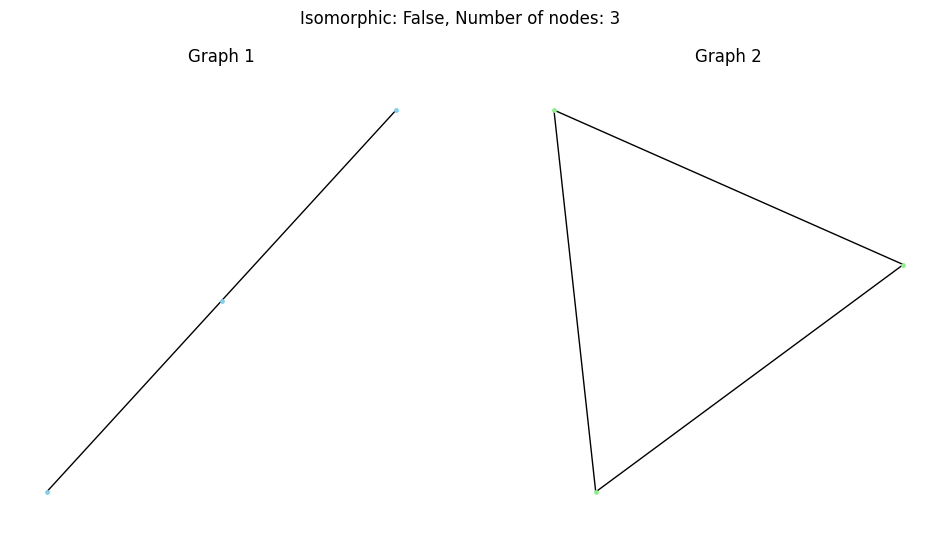

In [7]:
# Generate an example pair of graphs
is_isomorphic = False
example_pair = generate_graph_pair(3, is_isomorphic)  # Change to False to generate non-isomorphic pair
graph1, graph2, is_isomorphic = example_pair
print(nx.is_isomorphic(graph1, graph2))

# Visualize the generated graphs
visualize_graph_pair(graph1, graph2, is_isomorphic)

In [8]:
from math import floor
def create_dataset(max_nodes: int, generation_proportion: int, edge_prob: float) -> list[tuple[nx.Graph, nx.Graph, bool]]:
    dataset = []
    for num_nodes in range(3, max_nodes + 1):
        num_graphs = floor(generation_proportion * num_nodes)
        print(f"Generating {num_graphs} graphs with {num_nodes} nodes")
        for _ in range(num_graphs):
            is_isomorphic = random.choice([True, False])
            graph_pair = generate_graph_pair(num_nodes, is_isomorphic, edge_prob)
            dataset.append(graph_pair)
    return dataset

In [9]:
dataset = create_dataset(10, 1, 0.5)

Generating 3 graphs with 3 nodes
Generating 4 graphs with 4 nodes
Generating 5 graphs with 5 nodes
Generating 6 graphs with 6 nodes
Generating 7 graphs with 7 nodes
Generating 8 graphs with 8 nodes
Generating 9 graphs with 9 nodes
Generating 10 graphs with 10 nodes


In [10]:
len(dataset)

52

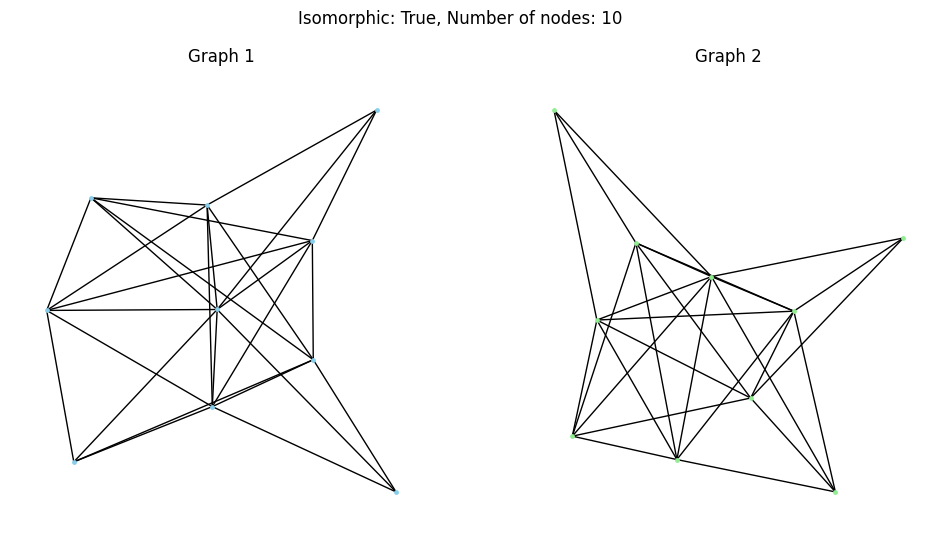

In [11]:
visualize_graph_pair(*dataset[51])

In [12]:
# Separate graph pairs and labels
graph_pairs = [(g1, g2) for g1, g2, _ in dataset]
labels = [label for _, _, label in dataset]


In [13]:
import os
import readARGdbFiles
import load_adj_mat
import get_graph_pairs_and_labels
import Graph_Isomorphism_Network
import numpy as np
import dgl
import tensorflow as tf
import numpy as np
from dgl.nn import GraphConv
import torch
import dgl
import torch
import torch.nn as nn
from dgl.nn import GraphConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2023-12-09 16:25:59.046896: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-09 16:25:59.047020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-09 16:25:59.048237: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-09 16:25:59.054197: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 16:26:00.331324: W tensorflow/compiler/tf2

In [31]:
def convert_to_dgl(graph):
    # Convert a NetworkX graph to a DGL graph
    return dgl.from_networkx(graph)

# Convert each graph in the pairs to DGL format
dgl_graph_pairs = [(convert_to_dgl(g1), convert_to_dgl(g2)) for g1, g2 in graph_pairs]


In [32]:
train_pairs, test_pairs, train_labels, test_labels = train_test_split(dgl_graph_pairs, labels, test_size=0.2, random_state=42)

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl.nn import GraphConv

class GIN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GIN, self).__init__()
        self.conv1 = GraphConv(input_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.compare = nn.Linear(hidden_dim * 2, hidden_dim)  # Layer to compare two graph representations
        self.classify = nn.Linear(hidden_dim, output_dim)  # Final classifier

    def forward(self, g1, g2, features1, features2):
        # Process the first graph
        h1 = self.process_graph(g1, features1)

        # Process the second graph
        h2 = self.process_graph(g2, features2)

        # Compare the two graph representations
        comparison = torch.cat((h1, h2), dim=1)  # Concatenate the representations
        comparison = F.relu(self.compare(comparison))

        # Classify the comparison
        return torch.sigmoid(self.classify(comparison))

    def process_graph(self, g, features):
        # Graph convolution layers
        x = F.relu(self.conv1(g, features))
        x = F.relu(self.conv2(g, x))

        # Global mean pooling
        with g.local_scope():
            g.ndata['h'] = x
            hg = dgl.mean_nodes(g, 'h')
            return hg


In [73]:
def train_step(model, optimizer, loss_fn, graph_pairs, labels):
    model.train()
    total_loss = 0
    for (g1, g2), label in zip(graph_pairs, labels):
        # Create node features for each graph
        h1 = torch.ones((g1.number_of_nodes(), 16), dtype=torch.float32)
        h2 = torch.ones((g2.number_of_nodes(), 16), dtype=torch.float32)

        optimizer.zero_grad()
        prediction = model(g1, g2, h1, h2)
        prediction = prediction.view(-1)  # Reshape to match label dimension
        label_tensor = torch.tensor([label], dtype=torch.float32)
        loss = loss_fn(prediction, label_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(graph_pairs)



In [74]:
def evaluate(model, graph_pairs, labels):
    model.eval()
    correct = 0
    with torch.no_grad():
        for (g1, g2), label in zip(graph_pairs, labels):
            # Create node features for each graph
            h1 = torch.ones((g1.number_of_nodes(), 16), dtype=torch.float32)
            h2 = torch.ones((g2.number_of_nodes(), 16), dtype=torch.float32)

            # Get predictions for the graph pair
            prediction = model(g1, g2, h1, h2)
            prediction = (prediction > 0.5).float()  # Threshold for binary classification

            correct += (prediction.view(-1) == label).sum().item()

    return correct / len(graph_pairs)


In [75]:
# Initialize model, loss function, and optimizer
model = GIN(input_dim=16, hidden_dim=32, output_dim=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [76]:
# Example training loop
for epoch in range(10):
    loss = train_step(model, optimizer, loss_fn, train_pairs, train_labels)
    print(f"Epoch {epoch}, Loss: {loss}")
test_accuracy = evaluate(model, test_pairs, test_labels)
print(f"Test Accuracy: {test_accuracy}")

Epoch 0, Loss: 0.7380911693340395
Epoch 1, Loss: 0.7027681906048845
Epoch 2, Loss: 0.6931471940947742
Epoch 3, Loss: 0.6931471882796869
Epoch 4, Loss: 0.693147186825915
Epoch 5, Loss: 0.693147186825915
Epoch 6, Loss: 0.693147186825915
Epoch 7, Loss: 0.693147186825915
Epoch 8, Loss: 0.693147186825915
Epoch 9, Loss: 0.693147186825915
Test Accuracy: 0.45454545454545453


Pair 1: Predicted - Non-Isomorphic, Actual - Non-Isomorphic


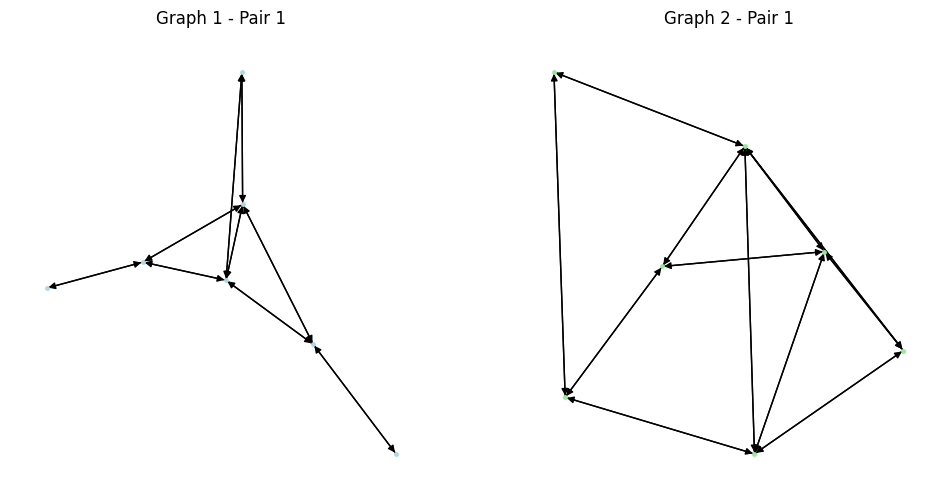

Pair 2: Predicted - Non-Isomorphic, Actual - Isomorphic


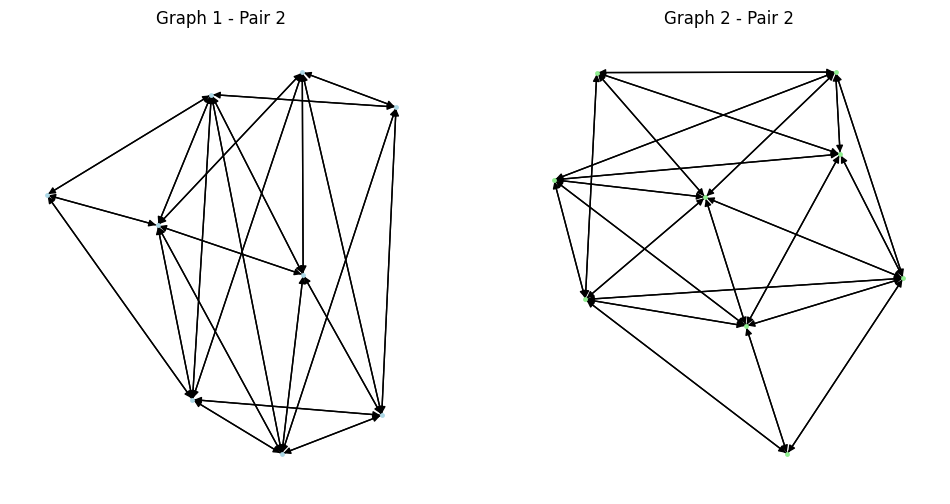

Pair 3: Predicted - Non-Isomorphic, Actual - Isomorphic


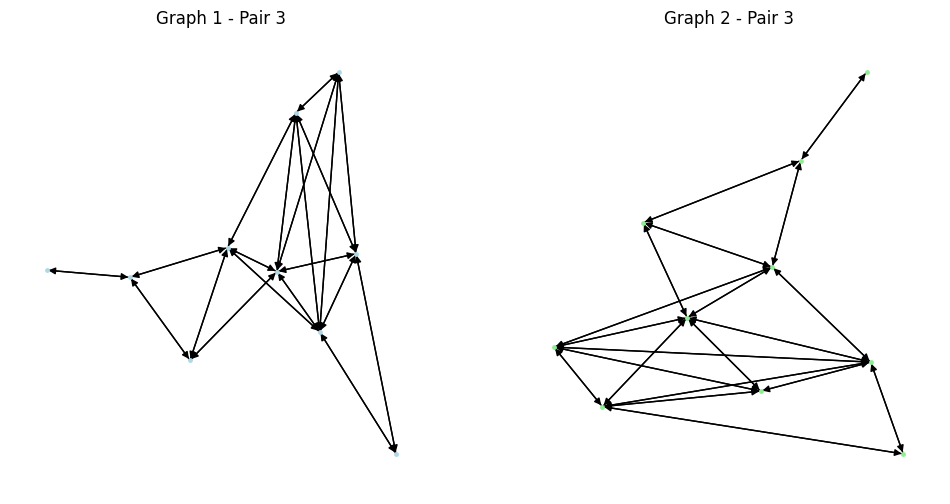

Pair 4: Predicted - Non-Isomorphic, Actual - Non-Isomorphic


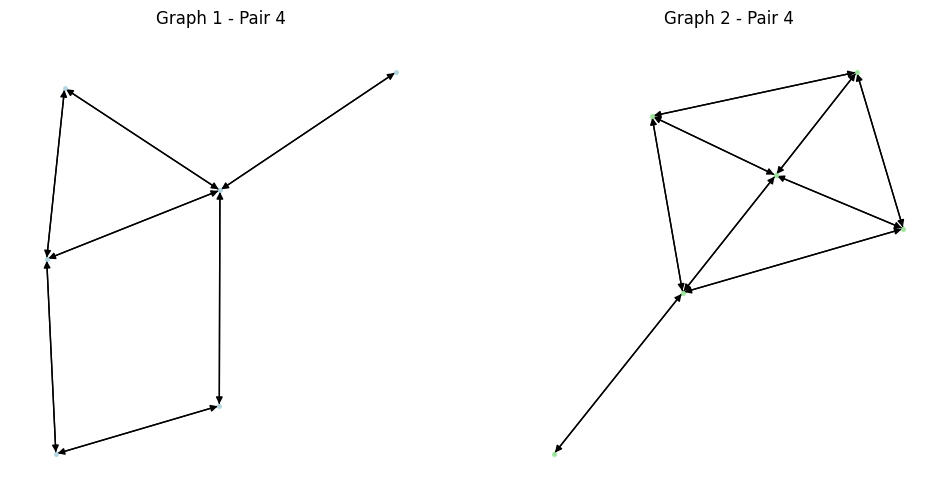

Pair 5: Predicted - Non-Isomorphic, Actual - Isomorphic


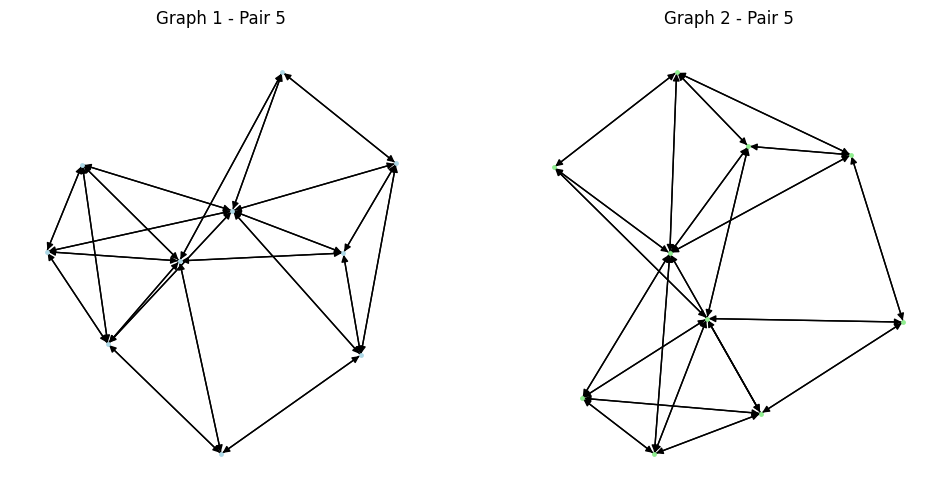

In [79]:
import matplotlib.pyplot as plt
import networkx as nx
import torch

# Function to convert DGL graph to NetworkX graph for visualization
def dgl_to_networkx(dgl_graph):
    g = nx.Graph()
    g.add_nodes_from(range(dgl_graph.number_of_nodes()))
    g.add_edges_from(zip(*dgl_graph.edges()))
    return g

# Select a few graph pairs from your test set
selected_pairs = test_pairs[:5]  # Change as needed
selected_labels = test_labels[:5]

# Get predictions
model.eval()
with torch.no_grad():
    predictions = []
    for g1, g2 in selected_pairs:
        h1 = torch.ones((g1.number_of_nodes(), 16), dtype=torch.float32)
        h2 = torch.ones((g2.number_of_nodes(), 16), dtype=torch.float32)
        pred = model(g1, g2, h1, h2)
        predictions.append(pred.item() > 0.5)  # Assuming threshold of 0.5 for binary classification

# Visualize the graphs and compare predictions to labels
for i, ((g1, g2), label, pred) in enumerate(zip(selected_pairs, selected_labels, predictions)):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    nx.draw(g1.to_networkx(), with_labels=False, node_color='lightblue', node_size=6)
    plt.title(f"Graph 1 - Pair {i+1}")

    plt.subplot(122)
    nx.draw(g2.to_networkx(), with_labels=False, node_color='lightgreen', node_size=6)
    # nx.draw(dgl_to_networkx(g2), with_labels=False, node_color='lightgreen')
    plt.title(f"Graph 2 - Pair {i+1}")

    print(f"Pair {i+1}: Predicted - {'Isomorphic' if pred else 'Non-Isomorphic'}, Actual - {'Isomorphic' if label else 'Non-Isomorphic'}")
    plt.show()


In [33]:
class GIN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GIN, self).__init__()
        self.conv1 = GraphConv(input_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, output_dim)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = torch.relu(self.conv2(g, x))
        with g.local_scope():
            g.ndata['h'] = x
            hg = dgl.mean_nodes(g, 'h')
            return self.classify(hg)

In [34]:
# Initialize model, loss function, and optimizer
model = GIN(input_dim=16, hidden_dim=32, output_dim=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [36]:
def evaluate(model, graph_pairs, labels):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computation
        for (g1, g2), label in zip(graph_pairs, labels):
            h1 = torch.ones((g1.number_of_nodes(), 16), dtype=torch.float32)
            h2 = torch.ones((g2.number_of_nodes(), 16), dtype=torch.float32)

            pred1 = model(g1, h1)
            pred2 = model(g2, h2)
            
            prediction = torch.abs(pred1 - pred2)
            predicted_label = (prediction.view(-1) > 0.5).float()  # Convert to binary label
            
            correct += (predicted_label == label).sum().item()
            # total += label.size(0)
            total += 1

    return correct / total


In [37]:
def train_step(model, optimizer, loss_fn, graph_pairs, labels):
    model.train()
    total_loss = 0
    for (g1, g2), label in zip(graph_pairs, labels):
        # Initialize node features for each graph
        h1 = torch.ones((g1.number_of_nodes(), 16), dtype=torch.float32)
        h2 = torch.ones((g2.number_of_nodes(), 16), dtype=torch.float32)
        
        optimizer.zero_grad()
        # Get predictions for each graph
        pred1 = model(g1, h1)
        pred2 = model(g2, h2)

        print("====")
        print(type(pred1))
        print(pred1)
        print(type(g1))
        print("====")
        
        # Combine predictions (you may need to adjust this part based on your specific task)
        prediction = torch.abs(pred1 - pred2)
        prediction = prediction.view(-1)  # Reshape to match label dimension
        label_tensor = torch.tensor([label], dtype=torch.float32)
        
        loss = loss_fn(prediction, label_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(graph_pairs)


In [ ]:
# Example training loop
for epoch in range(10):
    loss = train_step(model, optimizer, loss_fn, train_pairs, train_labels)
    print(f"Epoch {epoch}, Loss: {loss}")
test_accuracy = evaluate(model, test_pairs, test_labels)
print(f"Test Accuracy: {test_accuracy}")

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph(dgl_graph):
    # Convert DGLGraph to NetworkX graph for visualization
    nx_graph = dgl.to_networkx(dgl_graph)
    # Draw the graph
    nx.draw(nx_graph, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
    plt.show()

# Select a few sample pairs for inspection
sample_pairs = test_pairs[:7]  # Adjust the number as needed
sample_labels = test_labels[:7]

# Run predictions on these pairs
model.eval()
sample_predictions = []
with torch.no_grad():
    for (g1, g2) in sample_pairs:
        h1 = torch.ones((g1.number_of_nodes(), 16), dtype=torch.float32)
        h2 = torch.ones((g2.number_of_nodes(), 16), dtype=torch.float32)
        pred1 = model(g1, h1)
        pred2 = model(g2, h2)
        prediction = torch.abs(pred1 - pred2)
        predicted_label = (prediction.view(-1) > 0.5).float()  # Convert to binary label
        sample_predictions.append(predicted_label.item())

# Visualize the graphs and display predictions
for i, ((g1, g2), pred, label) in enumerate(zip(sample_pairs, sample_predictions, sample_labels)):
    print(f"Graph Pair {i+1}:")
    print("Graph 1:")
    visualize_graph(g1)
    print("Graph 2:")
    visualize_graph(g2)
    print(f"Predicted Label: {pred}, Actual Label: {label}, G1 num nodes: {g1.number_of_nodes()}, G2 num nodes: {g2.number_of_nodes()}")
